# Inference using the SynFerm models

In principle, this notebook works the same as `inference.ipynb`, but we keep it separate for reproducibility of the virtual library predictions and also because here we will do some specific steps like I/O directly to the database.


In [1]:
import pathlib
import statistics
import sys
import sqlite3
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader

from src.util.definitions import TRAINED_MODEL_DIR, LOG_DIR, DATA_ROOT
from src.model.classifier import load_trained_model
from src.data.dataloader import SynFermDataset, collate_fn
from reaction_generator import SFReactionGenerator

In [2]:
# paths to the best models
model_0D_name = "2023-11-29-145809_246697_fold0"
model_0D = TRAINED_MODEL_DIR / model_0D_name / "last-epoch42-val_loss0.20.ckpt"  # FFN
# path to the OneHotEncoder state for model_0D
ohe_state_dict = LOG_DIR / "OHE_state_dict_YCYzhoYPdFmypyNV.json"
assert model_0D.is_file()
assert ohe_state_dict.is_file()

To use the notebook on your products, change `raw_dir` to the directory that your CSV file containing SMILES is in. Then change `filename_base` to the filename of your csv file without the `.csv` suffix. If you do not want to use all the SMILES in your file (e.g. because some are not valid SLAP products), suppy a `valid_idx_file`. You can set the value to `None` if you want to use all SMILES.

In [3]:
# Import product SMILES
raw_dir = DATA_ROOT
dbname = "50k_project.db"
con = sqlite3.connect(DATA_ROOT / dbname)
# n.b. we just select everything now, later filter for things that the 0D model cannot handle.
# Here we don't care whether the reaction has been seen before, we can merge with the reaction data later
res = con.execute("SELECT id, long_name, SMILES FROM virtuallibrary WHERE type = 'A';").fetchall()
df = pd.DataFrame(res, columns=["vl_id", "long_name", "product_A_smiles"])
df.head()

,vl_id,long_name,product_A_smiles
0,1,2-Pyr002 + Fused002 + TerABT001,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C...
1,2,2-Pyr002 + Fused002 + TerABT004,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C...
2,3,2-Pyr002 + Fused002 + TerABT005,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C...
3,4,2-Pyr002 + Fused002 + TerABT006,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C...
4,5,2-Pyr002 + Fused002 + TerABT007,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C...


In [4]:
# check if all these were actually in the training data for the model we use
dfs = [pd.read_csv(TRAINED_MODEL_DIR / model_0D_name / f"train_{bb}.csv") for bb in ["initiators", "monomers", "terminators"]]
used_building_blocks = pd.concat(dfs)
used_building_blocks    


,long,smiles
0,2-Pyr003,O=C(c1cccc(Cl)n1)[B-](F)(F)F
1,2-Pyr006,O=C(c1ccc(Br)cn1)[B-](F)(F)F
2,2-Pyr007,O=C(c1cccc(F)n1)[B-](F)(F)F
3,2-Pyr008,O=C(c1ccc(F)cn1)[B-](F)(F)F
4,2-Pyr009,COc1ccc(C(=O)[B-](F)(F)F)nc1
...,...,...
36,TerTH023,NNC(=S)c1cccc2[nH]ncc12
37,TerTH025,NNC(=S)c1c[nH]cn1
38,TerTH026,NNC(=S)c1cn[nH]c1
39,TerTH027,NNC(=S)c1ccc2[nH]nnc2c1


In [5]:
# unused building blocks will not be recognized by the one-hot encoder, so we filter for that
df = df.loc[df["long_name"].str.split("+").apply(lambda x: all([i.strip() in used_building_blocks["long"].values for i in x]))]
len(df)

197784

In [13]:
%%time
df[0:100]["product_A_smiles"].apply(lambda x: gen.get_reaction_smiles(x))

CPU times: user 4.59 s, sys: 4 ms, total: 4.59 s
Wall time: 4.59 s


3034    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3035    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3036    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3037    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3038    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
                              ...                        
3129    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3130    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3131    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3132    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3133    F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
Name: product_A_smiles, Length: 100, dtype: object

In [18]:
# first we need to generate the reactionSMILES. This will take a moment 
# (to be precise I expect it to take a bit over 2h. Of course one could optimize or parallelize but I'm going home now so who cares)
gen = SFReactionGenerator()
df["reaction_smiles_atom_mapped"] = df["product_A_smiles"].apply(lambda x: gen.get_reaction_smiles(x))
df.head()

,vl_id,long_name,product_A_smiles,reaction_smiles_atom_mapped
3034,3035,2-Pyr003 + Fused002 + TerABT001,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3035,3036,2-Pyr003 + Fused002 + TerABT004,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3036,3037,2-Pyr003 + Fused002 + TerABT005,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3037,3038,2-Pyr003 + Fused002 + TerABT006,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3038,3039,2-Pyr003 + Fused002 + TerABT007,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...


In [19]:
# save this
df.to_csv(DATA_ROOT / "virtual-library_reactionSMILES.csv")

In [20]:
# instantiate data set. This will also take a moment
data = SynFermDataset(
    name="virtual-library_reactionSMILES.csv",
    raw_dir=DATA_ROOT,
    reaction=True,
    global_features=["OHE", ],
    global_featurizer_state_dict_path=ohe_state_dict,
    graph_type="bond_edges",
    featurizers="custom",
    smiles_columns=["reaction_smiles_atom_mapped"],
    label_columns=None,
    task="multilabel"
)

Done saving data into cached files.


In [21]:
# run the predictions

# load the trained model 
model_0D = load_trained_model("FFN", model_0D)
model_0D.eval()
trainer = pl.Trainer(accelerator="gpu", logger=False, max_epochs=-1)
# prepare data
dl = DataLoader(data, collate_fn=collate_fn, num_workers=0)
# predict
probabilities_0D = torch.sigmoid(torch.concat(trainer.predict(model_0D, dl)))
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/julian/miniconda3/envs/synferm-predictions/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [22]:
probabilities_0D

tensor([[0.9998, 0.9709, 0.0057],
        [0.9862, 0.4023, 0.0026],
        [0.9999, 0.3290, 0.0070],
        ...,
        [0.9812, 0.0765, 0.0160],
        [0.9419, 0.2212, 0.0013],
        [0.9985, 0.9076, 0.0099]])

In [23]:
# load decision thresholds
with open(LOG_DIR / "thresholds" / f"{model_0D_name}.txt", "r") as f:
    thresholds = [float(i) for i in f.readlines()]
print(thresholds)

[0.56, 0.47, 0.49]


In [24]:
# apply the thresholds
preds = torch.stack([torch.where(probabilities_0D[:, i] > thresholds[i], 1, 0) for i in range(3)], dim=1)

In [25]:
# combine with data
df[["prob_A", "prob_B", "prob_C"]] = probabilities_0D
df[["pred_A", "pred_B", "pred_C"]] = preds 

In [26]:
df.head()

,vl_id,long_name,product_A_smiles,reaction_smiles_atom_mapped,prob_A,prob_B,prob_C,pred_A,pred_B,pred_C
3034,3035,2-Pyr003 + Fused002 + TerABT001,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.999829,0.970909,0.005744,1,1,0
3035,3036,2-Pyr003 + Fused002 + TerABT004,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.986192,0.402342,0.002565,1,0,0
3036,3037,2-Pyr003 + Fused002 + TerABT005,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.999942,0.328987,0.007021,1,0,0
3037,3038,2-Pyr003 + Fused002 + TerABT006,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.999719,0.288040,0.003463,1,0,0
3038,3039,2-Pyr003 + Fused002 + TerABT007,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.096645,0.197727,0.000008,0,0,0


In [27]:
# summarize our predictions
df["pred_A"].value_counts()

pred_A
1    158883
0     38901
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

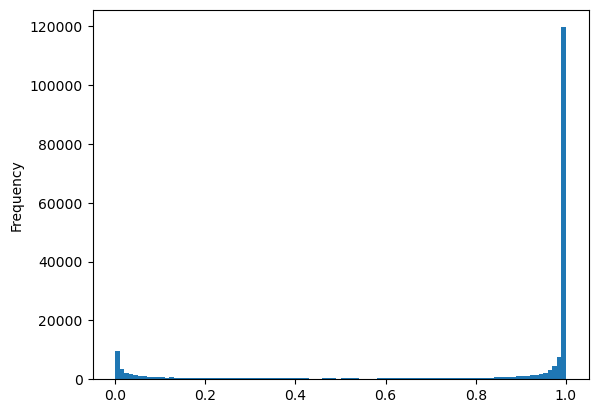

In [28]:
df["prob_A"].plot.hist(bins=100)

In [30]:
# write df to output file
df.to_csv(DATA_ROOT / f"virtual-library_predictions.csv", index=False)

In [33]:
from collections import defaultdict

In [40]:
vl_ids = defaultdict(dict)
longnames = {}

In [41]:
# get the mapping between vl_ids and longnames from db
res = con.execute("SELECT id, long_name, type FROM virtuallibrary").fetchall()
for row in res:
    vl_ids[row[1]][row[2]] = row[0]
    if row[2] == "A":
        longnames[row[0]] = row[1]

In [79]:
# write to db
cur = con.cursor()
for i, row in df[["vl_id", "pred_A", "pred_B", "pred_C"]].iterrows():
    # get vl_id for B and C
    other_ids = vl_ids[longnames[int(row["vl_id"])]]
    cur.execute("INSERT INTO virtuallibrary_predictions (vl_id, binary_outcome, binary_model) VALUES (?, ?, ?);",
               (row["vl_id"].item(), row["pred_A"].item(), model_0D_name))
    cur.execute("INSERT INTO virtuallibrary_predictions (vl_id, binary_outcome, binary_model) VALUES (?, ?, ?);",
               (other_ids["B"], row["pred_B"].item(), model_0D_name))
    cur.execute("INSERT INTO virtuallibrary_predictions (vl_id, binary_outcome, binary_model) VALUES (?, ?, ?);",
               (other_ids["C"], row["pred_C"].item(), model_0D_name))
con.commit()